# Classifying SNe

`Authors: Carolina Núñez, Vicente Pedreros, Antonio Vitalic`

The Dark Energy Science Collaboration released a new dataset with simulated light curves from LSST, including many classes of transient and persistent sources, including light curves and host information: [training set](https://portal.nersc.gov/cfs/lsst/DESC_TD_PUBLIC/ELASTICC/#trainingset)

In this project you are asked to build a classifier that can discriminate between the three classes of SNe: SNII (SNII-Templates, SNII-HostXT_V19 and SNII-NMF), SNIa (SNIa-91bg, SNIa-SALT2 and SNIax) and SNIbc (SNIb+HostXT_V19, SNIb-Templates, SNIc+HostXT_V19, SNIc-Templates, SNIcBL+HostXT_V19).
You can use metadata and light curve information.


Basic libraries are imported. Note that `Table` is used to transform the fits files to a pandas dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import fnmatch, glob

# Display all columns of pandas dataframe
pd.set_option('display.max_columns', None)

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Curating the data

The first thing to do is import the data. The function `to_df` will recieve the path to the first model of each class and return a dataframe. Note that the columns that will be used to classification are in the list `alert_name`.

In [3]:
head_filenames = fnmatch.filter(glob.glob('/content/drive/MyDrive/Proyecto_Astroinf/datos_renombrados/*'), '*HEAD.FITS.gz')
classes = ['SNIa', 'SNIbc', 'SNII']  # These are the classes that will be classified

# The following columns are the ones that will be used for classification
alert_name = ['SNID', 'RA', 'DEC', 'NOBS', 'MWEBV', 'MWEBV_ERR', 'REDSHIFT_HELIO', 'REDSHIFT_HELIO_ERR', 'HOSTGAL_RA', 'HOSTGAL_DEC', 'HOSTGAL_SNSEP', 'HOSTGAL_SPECZ',
            'HOSTGAL_SPECZ_ERR', 'HOSTGAL_PHOTOZ', 'HOSTGAL_PHOTOZ_ERR', 'HOSTGAL_ZPHOT_Q000', 'HOSTGAL_ZPHOT_Q010', 'HOSTGAL_ZPHOT_Q020', 'HOSTGAL_ZPHOT_Q030',
            'HOSTGAL_ZPHOT_Q040', 'HOSTGAL_ZPHOT_Q050', 'HOSTGAL_ZPHOT_Q060', 'HOSTGAL_ZPHOT_Q070', 'HOSTGAL_ZPHOT_Q080', 'HOSTGAL_ZPHOT_Q090', 'HOSTGAL_ZPHOT_Q100',
            'HOSTGAL_MAG_u', 'HOSTGAL_MAG_g', 'HOSTGAL_MAG_r', 'HOSTGAL_MAG_i', 'HOSTGAL_MAG_z', 'HOSTGAL_MAG_Y', 'HOSTGAL_MAGERR_u', 'HOSTGAL_MAGERR_g', 'HOSTGAL_MAGERR_r',
            'HOSTGAL_MAGERR_i', 'HOSTGAL_MAGERR_z', 'HOSTGAL_MAGERR_Y','HOSTGAL2_RA', 'HOSTGAL2_DEC', 'HOSTGAL2_SNSEP', 'HOSTGAL2_SPECZ', 'HOSTGAL2_SPECZ_ERR', 'HOSTGAL2_PHOTOZ',
            'HOSTGAL2_PHOTOZ_ERR', 'HOSTGAL2_ZPHOT_Q000', 'HOSTGAL2_ZPHOT_Q010', 'HOSTGAL2_ZPHOT_Q020', 'HOSTGAL2_ZPHOT_Q030',  'HOSTGAL2_ZPHOT_Q040', 'HOSTGAL2_ZPHOT_Q050',
            'HOSTGAL2_ZPHOT_Q060', 'HOSTGAL2_ZPHOT_Q070', 'HOSTGAL2_ZPHOT_Q080', 'HOSTGAL2_ZPHOT_Q090', 'HOSTGAL2_ZPHOT_Q100', 'HOSTGAL2_MAG_u', 'HOSTGAL2_MAG_g',
            'HOSTGAL2_MAG_r', 'HOSTGAL2_MAG_i', 'HOSTGAL2_MAG_z', 'HOSTGAL2_MAG_Y', 'HOSTGAL2_MAGERR_u', 'HOSTGAL2_MAGERR_g', 'HOSTGAL2_MAGERR_r', 'HOSTGAL2_MAGERR_i',
            'HOSTGAL2_MAGERR_z', 'HOSTGAL2_MAGERR_Y', 'MJD', 'BAND', 'FLUXCAL', 'FLUXCALERR']

In [4]:
def to_df(filename):
    """
    This function recieves a filename and will create a dataframe by using the HEAD's and PHOT's files.
    The columns corresponding to simulation information are droppped.
    """
    df_train = Table.read(filename, format='fits').to_pandas()
    for col in ['SNID', 'IAUC', 'SIM_MODEL_NAME', 'SIM_TYPE_NAME']:
        df_train[col] = df_train[col].apply(lambda row: row.decode("utf-8").strip())
    
    df_lc = Table.read(filename.replace("HEAD", "PHOT"), format='fits').to_pandas()
    for col in ['BAND', 'FIELD']:
        df_lc[col] = df_lc[col].apply(lambda row: row.decode("utf-8").strip())

    # The data from HEAD and PHOT are grouped.
    df = df_train.groupby("SNID").apply(lambda df: df_lc.iloc[df.PTROBS_MIN.iloc[0]-1:df.PTROBS_MAX.iloc[0]-1]).reset_index()
    df = pd.merge(df_train, df, left_on='SNID', right_on='SNID')
    
    # Only alert_name columns are considered
    df = df[alert_name]

    subclass = filename.replace('_HEAD.FITS.gz', '').replace('/content/drive/MyDrive/Proyecto_Astroinf/datos_renombrados/', '')  # Name of the subclass
    subclasses = [subclass for x in range(len(df))]  # List of strings containing the name of the subclass

    _class_ = subclass[:4]  # Name of the class
    classes = [_class_ for x in range(len(df))]  # List of strings containing the name of the class

    # A column containing the class and subclass are added
    df.insert(0, 'SUBCLASS', subclasses)
    df.insert(0, 'CLASS', classes)
    df.replace(['SNIb', 'SNIc'], 'SNIbc', inplace=True)

    return df


In [5]:
dataframes = [to_df(filename) for filename in head_filenames]

df_train = pd.concat(dataframes)
df_train

,CLASS,SUBCLASS,SNID,RA,DEC,NOBS,MWEBV,MWEBV_ERR,REDSHIFT_HELIO,REDSHIFT_HELIO_ERR,HOSTGAL_RA,HOSTGAL_DEC,HOSTGAL_SNSEP,HOSTGAL_SPECZ,HOSTGAL_SPECZ_ERR,HOSTGAL_PHOTOZ,HOSTGAL_PHOTOZ_ERR,HOSTGAL_ZPHOT_Q000,HOSTGAL_ZPHOT_Q010,HOSTGAL_ZPHOT_Q020,HOSTGAL_ZPHOT_Q030,HOSTGAL_ZPHOT_Q040,HOSTGAL_ZPHOT_Q050,HOSTGAL_ZPHOT_Q060,HOSTGAL_ZPHOT_Q070,HOSTGAL_ZPHOT_Q080,HOSTGAL_ZPHOT_Q090,HOSTGAL_ZPHOT_Q100,HOSTGAL_MAG_u,HOSTGAL_MAG_g,HOSTGAL_MAG_r,HOSTGAL_MAG_i,HOSTGAL_MAG_z,HOSTGAL_MAG_Y,HOSTGAL_MAGERR_u,HOSTGAL_MAGERR_g,HOSTGAL_MAGERR_r,HOSTGAL_MAGERR_i,HOSTGAL_MAGERR_z,HOSTGAL_MAGERR_Y,HOSTGAL2_RA,HOSTGAL2_DEC,HOSTGAL2_SNSEP,HOSTGAL2_SPECZ,HOSTGAL2_SPECZ_ERR,HOSTGAL2_PHOTOZ,HOSTGAL2_PHOTOZ_ERR,HOSTGAL2_ZPHOT_Q000,HOSTGAL2_ZPHOT_Q010,HOSTGAL2_ZPHOT_Q020,HOSTGAL2_ZPHOT_Q030,HOSTGAL2_ZPHOT_Q040,HOSTGAL2_ZPHOT_Q050,HOSTGAL2_ZPHOT_Q060,HOSTGAL2_ZPHOT_Q070,HOSTGAL2_ZPHOT_Q080,HOSTGAL2_ZPHOT_Q090,HOSTGAL2_ZPHOT_Q100,HOSTGAL2_MAG_u,HOSTGAL2_MAG_g,HOSTGAL2_MAG_r,HOSTGAL2_MAG_i,HOSTGAL2_MAG_z,HOSTGAL2_MAG_Y,HOSTGAL2_MAGERR_u,HOSTGAL2_MAGERR_g,HOSTGAL2_MAGERR_r,HOSTGAL2_MAGERR_i,HOSTGAL2_MAGERR_z,HOSTGAL2_MAGERR_Y,MJD,BAND,FLUXCAL,FLUXCALERR
0,SNII,SNII-NMF,67483901,16.368661,-41.541637,132,0.008264,0.000413,0.090963,0.02984,16.367049,-41.539995,3.795247,-9.0,-9.0,0.090963,0.02984,-0.014997,0.062613,0.072343,0.079363,0.085353,0.090963,0.096563,0.102563,0.109573,0.119303,0.270703,20.769352,19.409679,18.521891,18.147284,17.878895,17.606148,0.00691,0.00502,0.0050,0.0050,0.00501,0.00502,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,60871.3943,i,-6.731427,7.358455
1,SNII,SNII-NMF,67483901,16.368661,-41.541637,132,0.008264,0.000413,0.090963,0.02984,16.367049,-41.539995,3.795247,-9.0,-9.0,0.090963,0.02984,-0.014997,0.062613,0.072343,0.079363,0.085353,0.090963,0.096563,0.102563,0.109573,0.119303,0.270703,20.769352,19.409679,18.521891,18.147284,17.878895,17.606148,0.00691,0.00502,0.0050,0.0050,0.00501,0.00502,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,60871.4132,z,-8.563615,8.348427
2,SNII,SNII-NMF,67483901,16.368661,-41.541637,132,0.008264,0.000413,0.090963,0.02984,16.367049,-41.539995,3.795247,-9.0,-9.0,0.090963,0.02984,-0.014997,0.062613,0.072343,0.079363,0.085353,0.090963,0.096563,0.102563,0.109573,0.119303,0.270703,20.769352,19.409679,18.521891,18.147284,17.878895,17.606148,0.00691,0.00502,0.0050,0.0050,0.00501,0.00502,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,60877.4268,r,2.500511,4.012604
3,SNII,SNII-NMF,67483901,16.368661,-41.541637,132,0.008264,0.000413,0.090963,0.02984,16.367049,-41.539995,3.795247,-9.0,-9.0,0.090963,0.02984,-0.014997,0.062613,0.072343,0.079363,0.085353,0.090963,0.096563,0.102563,0.109573,0.119303,0.270703,20.769352,19.409679,18.521891,18.147284,17.878895,17.606148,0.00691,0.00502,0.0050,0.0050,0.00501,0.00502,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,60881.4389,r,1.031235,3.955907
4,SNII,SNII-NMF,67483901,16.368661,-41.541637,132,0.008264,0.000413,0.090963,0.02984,16.367049,-41.539995,3.795247,-9.0,-9.0,0.090963,0.02984,-0.014997,0.062613,0.072343,0.079363,0.085353,0.090963,0.096563,0.102563,0.109573,0.119303,0.270703,20.769352,19.409679,18.521891,18.147284,17.878895,17.606148,0.00691,0.00502,0.0050,0.0050,0.00501,0.00502,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,60884.4122,i,4.555480,4.583658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

### Visualization of data

A count plot, 20 lightcurves per class and histograms are presented.

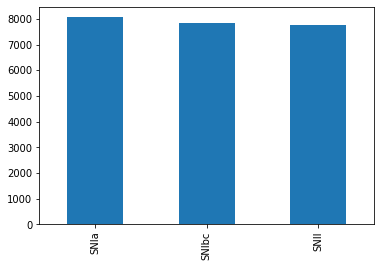

In [6]:
ax = df_train.groupby('SNID').max().CLASS.value_counts().plot.bar()

In [7]:
colors = {'u': 'b', 'g': 'g', 'r': 'r', 'i': 'orange', 'z': 'brown', 'Y': 'k'}

In [8]:
def plot_lc(SNID, df, path=None):
    """
    Plots the lightcurves, generating a lightcurve (lc) for each band, but it shows
    all bands in one figure.
    """
    fig, ax = plt.subplots(figsize=(8, 3))
    for idx, c in enumerate(colors.keys()):
        mask = (df.SNID == str(SNID)) & (df.BAND == c)
        if mask.sum() > 0:
            ax.errorbar(df.loc[mask].MJD, df.loc[mask].FLUXCAL,
                        yerr=df.loc[mask].FLUXCALERR, color=list(colors.values())[idx], fmt='o', ms=3, lw=0, elinewidth=1, label=c)

    ax.set_xlabel('mjd')
    ax.set_ylabel('Flux')
    ax.legend()
    ax.set_title(str(SNID) + ' ' + df.loc[mask].iloc[0].CLASS)
    if path is not None:
        fig.savefig(path+'lc_'+SNID+'.png')

In [9]:
np.random.seed(73)

snids_20sample = [list(df_train.loc[df_train.CLASS.isin([df_train.CLASS.unique()[i]])].sample(
    20).SNID) for i in range(len(df_train.CLASS.unique()))]

snids_20 = sum(snids_20sample, [])

In [10]:
"""for snid in snids_20:
    plot_lc(str(snid), df_train)
    plt.show()
"""

'for snid in snids_20:\n    plot_lc(str(snid), df_train)\n    plt.show()\n'

In [11]:
snids_array = df_train.SNID.unique()

df_train['FLUXCAL'] = df_train.groupby('BAND')['FLUXCAL'].transform(
    lambda x: np.where(x < 0, x.mean(), x))


In [12]:
snids = df_train.SNID.unique()

Text(0.5, 1.0, 'Flux histogram')

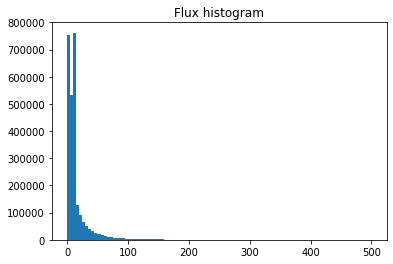

In [13]:
# Histograma de flujos de todos los datos
counts, bins = np.histogram(
    df_train.FLUXCAL.to_numpy(), bins=100, range=(0, 500))
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Flux histogram')


Text(0.5, 1.0, 'Flux error histogram')

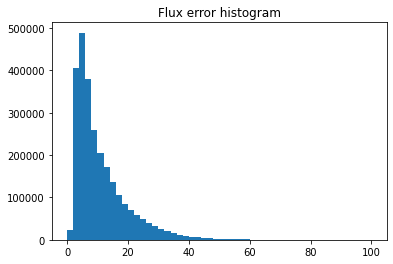

In [14]:
# Flux Error Histogram
counts, bins = np.histogram(
    df_train.FLUXCALERR.to_numpy(), bins=50, range=(0, 100))
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Flux error histogram')

Text(0.5, 1.0, 'Signal to noise ratio histogram')

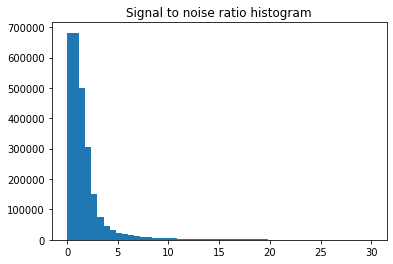

In [15]:
# SNR Histogram
counts, bins = np.histogram(df_train.FLUXCAL.to_numpy(
)/df_train.FLUXCALERR.to_numpy(), bins=50, range=(0, 30))
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Signal to noise ratio histogram')


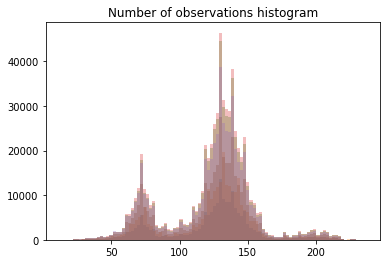

In [16]:
# Number of observations Histogram

fig, ax = plt.subplots()
for c in list(colors.keys()):
    counts, bins = np.histogram(df_train.loc[df_train.BAND == c].NOBS.to_numpy(), bins=100)
    ax.hist(bins[:-1], bins, weights=counts, alpha=0.3)
plt.title('Number of observations histogram');

In [17]:
w

NameError: ignored

In [ ]:
#Filtros (Colores de las galaxias)
df_train.insert(39, 'HOSTGAL_g-r', df_train.HOSTGAL_MAG_g - df_train.HOSTGAL_MAG_r)
df_train.insert(40, 'HOSTGAL_u-r', df_train.HOSTGAL_MAG_u - df_train.HOSTGAL_MAG_r)
df_train.insert(41, 'HOSTGAL_i-z', df_train.HOSTGAL_MAG_i - df_train.HOSTGAL_MAG_z)

df_train.insert(69, 'HOSTGAL2_g-r', df_train.HOSTGAL2_MAG_g - df_train.HOSTGAL2_MAG_r)
df_train.insert(70, 'HOSTGAL2_u-r', df_train.HOSTGAL2_MAG_u - df_train.HOSTGAL2_MAG_r)
df_train.insert(71, 'HOSTGAL2_i-z', df_train.HOSTGAL2_MAG_i - df_train.HOSTGAL2_MAG_z)
# No entrega info sobre si una galaxia es más roja o no, sino de la magnitud relativa g-r

## Building images

The goal of this section is to build images so a Neural Network can perform classification.

Since most of the objects have a NOBS higher than 60, images will consist in matrixes of 6 x 60, where each row will represent a band.

In [24]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df_train.BAND = encoder.fit_transform(df_train.BAND)

color = np.sort(df_train.BAND.unique())
color

array([0, 1, 2, 3, 4, 5])

To split the data into training and test sets, the fact that the dataframe contains multiple rows for an object needs to be considered. So, the array containing the SNID's (`snids_array`) will be splitted into a train and test array.

In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split, KFold

np.random.seed(4501)

snids_train, snids_test = train_test_split(snids_array, test_size=0.2, train_size=0.2, random_state=1)

In [ ]:
X_df_train = df_train.loc[df_train.SNID.isin(snids_train)].drop(['CLASS', 'SUBCLASS'], axis=1).reset_index()
X_df_test = df_train.loc[df_train.SNID.isin(snids_test)].drop(['CLASS', 'SUBCLASS'], axis=1).reset_index()

y_train = df_train.loc[df_train.SNID.isin(snids_train)]['CLASS']
y_test = df_train.loc[df_train.SNID.isin(snids_test)]['CLASS']

In [ ]:
X_df_train

In [ ]:
X_df_train = X_df_train[['SNID', 'MJD', 'BAND', 'FLUXCAL', 'FLUXCALERR']]

In [ ]:
len(X_df_train)

In [ ]:
X_train = np.zeros((len(X_df_train.SNID.unique()), 6, 600))

for i in range(len(X_df_train.SNID.unique())):
  for c in color:
    mask = (X_df_train.SNID == X_df_train.SNID[i]) & (X_df_train.BAND == c)
    data = X_df_train.loc[mask][['MJD', 'FLUXCAL']].to_numpy()
    for h in range(len(data)):
      if 60650 <= data[h][0] < 61250:
        ind = int(data[h][0] - 60650)
        X_train[i][c][ind] = data[h][1]

In [ ]:
counts, bins = np.histogram(df_train.NOBS, bins=100)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.3)
plt.title('Number of observations histogram')

In [ ]:
df = df_train.copy()
df.drop(df[df.NOBS < 60].index, inplace = True)

# Building images (2nd try)

In [18]:
# Redondeo MJD
df_train.MJD = np.round(df_train.MJD, 0)

In [19]:
# Creao dataframe con las columnas que voy a usar
df = df_train[['SNID', 'CLASS', 'MJD', 'BAND', 'FLUXCAL', 'FLUXCALERR']].copy()

In [20]:
# defino el rango de MJD que voy a considerar 
df.drop(df[df.MJD < 60500].index, inplace=True)
df.drop(df[df.MJD > 61200].index, inplace=True)

In [21]:
snids2 = df.SNID.unique()
len(snids2)

12275

In [22]:
# Recorro cada banda de las SNID y agrego la media de los flujos con esas cond

def insert_mjd(SNIDS, df):
  arr = np.arange(60500, 61200)
  for mjd in arr:
    for c in color:
      mask = (df.SNID == SNIDS) & (df.BAND == c)
      f_median = df.loc[mask].FLUXCAL.median()
      err_median = df.loc[mask].FLUXCALERR.median()
      if (mjd in df[df.SNID == SNIDS].MJD) == False:
        a = pd.DataFrame([[SNIDS, df.loc[mask].CLASS, mjd, c, f_median, err_median]], 
                         columns=['SNID', 'CLASS', 'MJD', 'BAND', 'FLUXCAL', 'FLUXCALERR'])

        df.append(a) #Agrega la fila al final del df

    return df

In [23]:
for snid in snids2:
  insert_mjd(snid, df)

NameError: ignored

In [ ]:
df

In [ ]:
insert_mjd(snids2[0],df)

In [ ]:
mask = (df.SNID == snids2[0]) & (df.BAND == 'i')
df.loc[mask]

In [ ]:
df

In [ ]:
len(snids)

In [ ]:
other = df[(df.SNID == snids2[0]) | (df.SNID == snids2[340])].copy()


In [ ]:
other = other.SNID.apply(lambda x: insert_mjd(x, other))